Link to Medium blog post: https://towardsdatascience.com/beware-of-the-dummy-variable-trap-in-pandas-727e8e6b8bde

# Beware of the Dummy variable trap in pandas

### Encoding categorical variables with `pandas.get_dummies()`

As the name suggests, the pandas.get_dummies() function converts categorical variables into dummy or indicator variables. Let’s see it working through an elementary example. We first define a hypothetical dataset consisting of attributes of employees of a company and use it to predict the employees’ salaries.

In [2]:
import pandas as pd

In [3]:
df = pd.DataFrame({
    'Gender' : ['Female', 'Male', 'Male', 'Male', 'Male', 'Female', 'Male', 'Male','Male', 'Female','Male', 'Female'],
    'Age' : [41, 49, 37, 33, 27, 32, 59, 30, 38, 36, 35, 29],
    'EducationField': ['Life Sciences', 'Engineering', 'Life Sciences', 'Life Sciences', 'Medical', 'Life Sciences', 'Life Sciences', 'Life Sciences', 'Engineering', 'Medical', 'Life Sciences', 'Life Sciences'],
    'MonthlyIncome': [5993, 5130, 2090, 2909, 3468, 3068, 2670, 2693, 9526, 5237, 2426, 4193]
})

In [4]:
df

,Gender,Age,EducationField,MonthlyIncome
0,Female,41,Life Sciences,5993
1,Male,49,Engineering,5130
2,Male,37,Life Sciences,2090
3,Male,33,Life Sciences,2909
4,Male,27,Medical,3468
5,Female,32,Life Sciences,3068
6,Male,59,Life Sciences,2670
7,Male,30,Life Sciences,2693
8,Male,38,Engineering,9526
9,Female,36,Medical,5237


We can see that there are two categorical columns in the above dataset i.e. Genderand EducationField. Let’s encode them into numerical quantities using pandas.get_dummies() which returns a dummy-encoded dataframe.

In [5]:
pd.get_dummies(df)

,Age,MonthlyIncome,Gender_Female,Gender_Male,EducationField_Engineering,EducationField_Life Sciences,EducationField_Medical
0,41,5993,True,False,False,True,False
1,49,5130,False,True,True,False,False
2,37,2090,False,True,False,True,False
3,33,2909,False,True,False,True,False
4,27,3468,False,True,False,False,True
5,32,3068,True,False,False,True,False
6,59,2670,False,True,False,True,False
7,30,2693,False,True,False,True,False
8,38,9526,False,True,True,False,False
9,36,5237,True,False,False,False,True


The column Gender gets converted into two columns — Gender_Female and Gender_Male having values as either zero or one. For instance, Gender_Female has a value = 1 at places where the concerned employee is female and value = 0 when not. The same is true for the column Gender_Male.

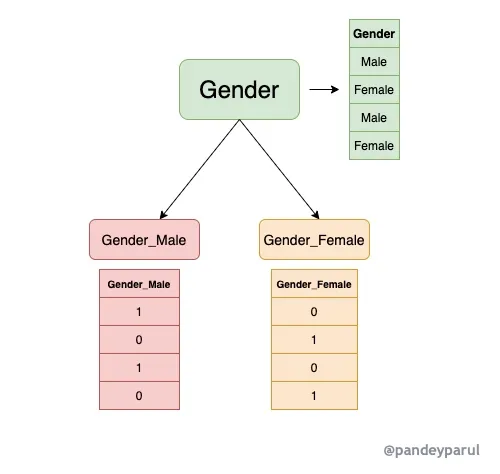

Similarly, the column EducationField also gets separated into three different columns based on the field of education. Things are pretty much apparent till now. However, the issue begins when we use this encoded dataset to train a model.

### The Dummy Variable Trap

Let’s say we want to use the given data to build a machine learning model that can predict employees' monthly salaries. This is a classic example of a regression problem where the target variable is MonthlyIncome. If we were to use pandas.get_dummies() to encode the categorical variables, the following issues could arise:

#### 1. The issue of Multicollinearity

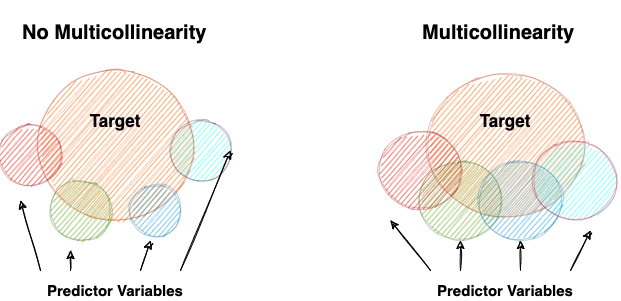

One of the assumptions of a regression model is that the observations must be independent of each other. Multicollinearity occurs when independent variables in a regression model are correlated. So why is correlation a problem? To help you understand the concept in detail and avoid re-inventing the wheel, I’ll point you to a great piece by Jim Frost, where he explains it very succinctly. The following paragraph is from the same article.

A key goal of regression analysis is to isolate the relationship between each independent variable and the dependent variable. The interpretation of a regression coefficient is that it represents the mean change in the dependent variable for each 1 unit change in an independent variable when you hold all of the other independent variables constant.

If all the variables are correlated, it will become difficult for the model to tell how strongly a particular variable affects the target since all the variables are related. In such a case, the coefficient of a regression model will not convey the correct information.

#### Multicollinearity issue with pandas.get_dummies

Consider the employee example above. Let’s isolate the Gender column from the dataset and encode it.

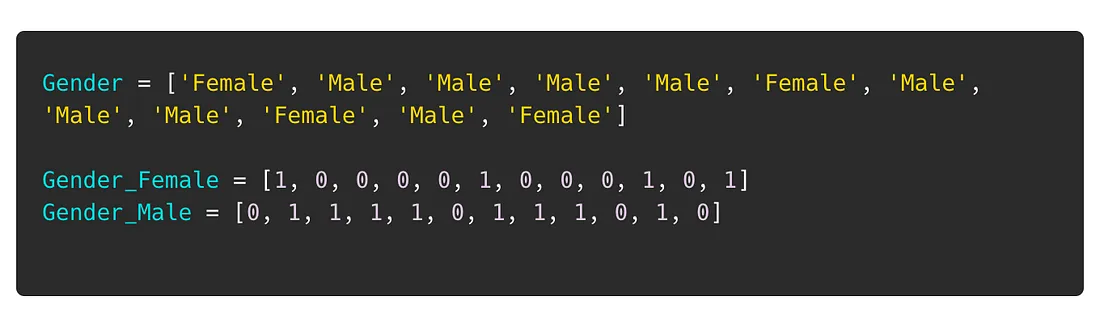

If we look closely, Gender_Female and Gender_Male columns are multi-collinear. This is because a value of 1 in one column automatically implies 0 in the other. This issue is termed a dummy variable trap and can be represented as :

In [ ]:
Gender_Female = 1 - Gender_Male

#### Solution: Drop the first column


Multi-collinearity is undesirable, and every time we encode variables with pandas.get_dummies(), we’ll encounter this issue. One way to overcome this issue is by dropping one of the generated columns. So, we can drop either Gender_Female or Gender_Male without potentially losing any information. Fortunately, pandas.get_dummies() has a parameter called drop_first which, when set to True, does precisely that.

In [7]:
pd.get_dummies(df, drop_first=True)

,Age,MonthlyIncome,Gender_Male,EducationField_Life Sciences,EducationField_Medical
0,41,5993,False,True,False
1,49,5130,True,False,False
2,37,2090,True,True,False
3,33,2909,True,True,False
4,27,3468,True,False,True
5,32,3068,False,True,False
6,59,2670,True,True,False
7,30,2693,True,True,False
8,38,9526,True,False,False
9,36,5237,False,False,True


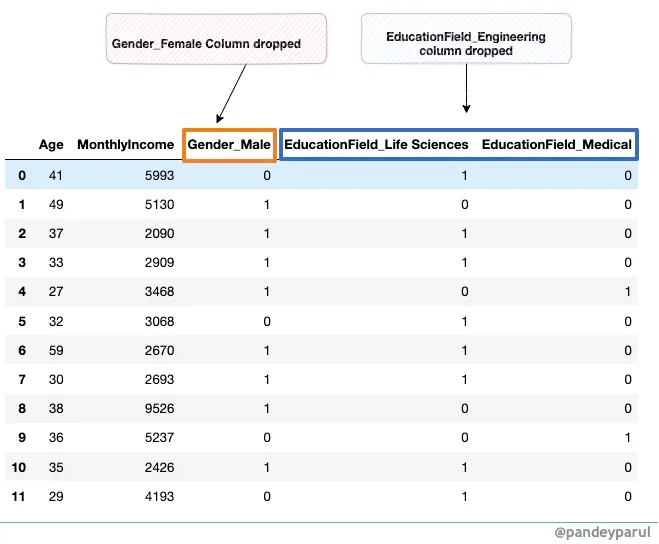

#### 2. Column Mismatch in train and test sets

To train a model with the given employee data, we’ll first split the dataset into train and test sets, keeping the test set aside so that our model never sees it.

In [8]:
from sklearn.model_selection import train_test_split
X = df.drop('MonthlyIncome', axis=1)
y = df['MonthlyIncome']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)


The next step would be to encode the categorical variables in the training set and the test set.

In [9]:
# Encoding Training set
pd.get_dummies(X_train)

,Age,Gender_Female,Gender_Male,EducationField_Engineering,EducationField_Life Sciences,EducationField_Medical
10,35,False,True,False,True,False
1,49,False,True,True,False,False
6,59,False,True,False,True,False
0,41,True,False,False,True,False
7,30,False,True,False,True,False
11,29,True,False,False,True,False
9,36,True,False,False,False,True
8,38,False,True,True,False,False
5,32,True,False,False,True,False


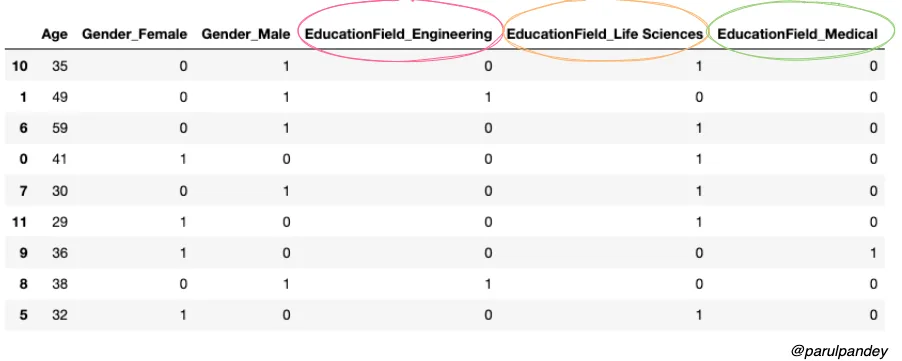

As expected, both the Gender and the EducationField attributes have been encoded into numerical quantities. Now we’ll apply the same process to the test dataset.

In [10]:
# Encoding Test set
pd.get_dummies(X_test)

,Age,Gender_Male,EducationField_Life Sciences,EducationField_Medical
2,37,True,True,False
3,33,True,True,False
4,27,True,False,True


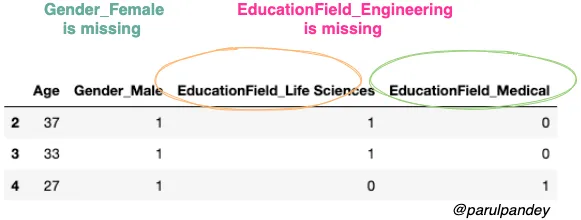

There is a column mismatch in the training and test set. This means the number of columns in the training set is not equal to the ones in the test set, and this will throw an error in the modeling process.

#### Solution 1: Handle unknown by using .reindex and .fillna()

One way of addressing this mismatch in categories would be to save the columns obtained after dummy encoding the training set in a list. Then, encode the test set as usual and use the columns of the encoded training set to align both the datasets. Let’s understand it through code:

In [11]:
# Dummy encoding Training set
X_train_encoded = pd.get_dummies(X_train)
# Saving the columns in a list
cols = X_train_encoded.columns.tolist()
# Viewing the first three rows of the encoded dataframe
X_train_encoded[:3]

,Age,Gender_Female,Gender_Male,EducationField_Engineering,EducationField_Life Sciences,EducationField_Medical
10,35,False,True,False,True,False
1,49,False,True,True,False,False
6,59,False,True,False,True,False


Now, we’ll encode the test set followed by realigning the training and test columns and filling in all missing values with zero.

In [12]:
X_test_encoded = pd.get_dummies(X_test)
X_test_encoded = X_test_encoded.reindex(columns=cols).fillna(0)
X_test_encoded

,Age,Gender_Female,Gender_Male,EducationField_Engineering,EducationField_Life Sciences,EducationField_Medical
2,37,0.0,True,0.0,True,False
3,33,0.0,True,0.0,True,False
4,27,0.0,True,0.0,False,True


As you can see, now both the datasets have the same number of columns.

#### Solution 2: Use One Hot Encoding

Another solution and a preferable one would be to use sklearn.preprocessing.OneHotEncoder().Additionally, one can use handle_unknown="ignore" to solve the potential issues due to rare categories.

In [ ]:
#One hot encoding the categorical columns in training set
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
train_enc = ohe.fit_transform(X_train[['Gender','EducationField']])
#Converting back to a dataframe 
pd.DataFrame(train_enc, columns=ohe.get_feature_names())[:3]

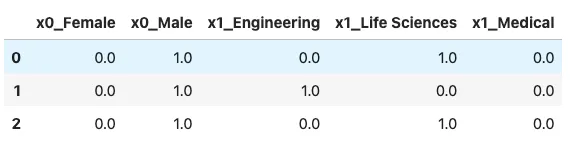

In [ ]:
# Transforming the test set
test_enc = ohe.fit_transform(X_test[['Gender','EducationField']])
#Converting back to a dataframe
pd.DataFrame(test_enc,columns=ohe.get_feature_names())

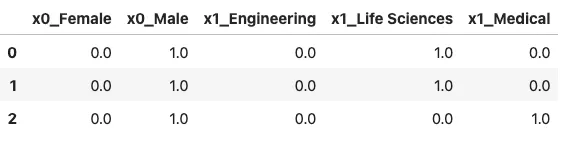

Note, you can also drop one of the categories per feature in OnehotEncoder by setting the parameter drop=’if_binary’.